<img src="images/mind_tree.jpg" align="center"/>

# A Mind Without Time: Forcasting the Conversion to Alzheimer's Disease

This project attempts to forcast the conversion of cognitively normal and persons with Mild Cognitive Impairment (MCI) to a diagnosis of Alzheimer's Disease (AD). Alzheimer's Disease is one of the most prevalent neurodegenerative disorders in North America. In Canada alone, there are 564,000 people diagnosed with dementia, a number that is expected to increase to nearly a million by 2031.Aside from the impact on an individual, dementia places a large burden on the healthcare system and persons involved with an affected individual. Dementia is currently estimated to cost 10.4 billion dollars in yearly expenses within Canada.

Early diagnosis of AD is associated with a higher quality of life and a reduced cost on a healthcare system. However, detecting AD early in the disease progression is difficult due to the multifaceted nature of how neurodegeneration affects the brain, cognitive processing, and behavior. Clinical evaluation relies on assessment of a myriad of cognitive tests and biomarkers that are not always identifiable in patients with MCI, a precursor to AD. 

The multifaceted impact of cognitive impairment and neurodegeneration in MCI and AD suggests that machine learning algorithms such as neural networks may be beneficial in identifying and predicting disease progression. Current studies typically only incorporate one form of data, however, often relying solely on features extracted from structural magnetic resonance imaging (MRI) scans. Other forms of data that show promise in classification with machine learning algorithms include cognitive assessments and the connectivity patterns of resting-state functional networks. This is because spatial and episodic memory, cognitive processes that are typically the first affected in MCI and AD, rely on complex, dynamic interactions of distributed neural networks and are therefore susceptible to the impact of neurodegeneration. Critically, there has yet to be an assessment of how machine learning algorithms perform using features extracted from structural and functional MRI data, as well as cognitive assessments. This project aims to remedy this.

**Target audience and use cases:**

Healthcare providers. Structural and resting-state functional MRIs are one of easiest and fastest methods of brain imaging. Using them to classify persons at risk or with AD would assist in providing targeted treatments.

**Notebook overview**

This notebook explores different machine learning approaches to predicting AD onset. It also covers model optimization.

## 3. Building a core model 

The first goal is to build a classification model that will classify individuals who convert from those that do not. We will use a reduced feature set in order to maximize the amount of datapoints being classified. These features will be based on demographic information, cognitive assessments, genetic, and structural MRI data as they are the variables that are recorded for the majority of the patients. Later, we will build reduced models that include other feature types and evaluate how they perform relative to our core model.

For our intial model, we will look at predicting AD onset just from the values at baseline. The reason is that this will provide the maximum time on average to target patients who will convert with early interventions.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed = 42

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# remove future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set plot style
plt.style.use('fivethirtyeight')

# set figure properties
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
df = pd.read_csv('df_final.csv', index_col=0)

In [3]:
df.columns

Index(['rid', 'viscode', 'd1', 'd2', 'dx_bl', 'dxchange', 'age', 'ptgender',
       'pteducat', 'ptethcat', 'ptmarry', 'cdrsb_bl', 'cdrsb', 'adas13_bl',
       'adas13', 'mmse_bl', 'mmse', 'moca', 'ecogptmem', 'ecogptvisspat',
       'ventricles_bl', 'wholebrain_bl', 'icv_bl', 'l_hippocampus_l',
       'l_hippocampus_r', 'x_hippocampus_l', 'x_hippocampus_r',
       'l_entorhinal_l', 'l_entorhinal_r', 'l_entorhinal_l_thick',
       'l_entorhinal_r_thick', 'x_entorhinal_l', 'x_entorhinal_r',
       'x_entorhinal_l_thick', 'x_entorhinal_r_thick', 'fdg', 'fdg_bl', 'pib',
       'av45', 'av45_bl', 'md_hippocampus_r', 'apoe4', 'converted', 'diff_1',
       'diff_2', 'x_hippocampus_l_bl', 'x_hippocampus_r_bl',
       'x_entorhinal_l_bl', 'x_entorhinal_r_bl', 'x_entorhinal_l_thick_bl',
       'x_entorhinal_r_thick_bl'],
      dtype='object')

In [4]:
df.head()

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,apoe4,converted,diff_1,diff_2,x_hippocampus_l_bl,x_hippocampus_r_bl,x_entorhinal_l_bl,x_entorhinal_r_bl,x_entorhinal_l_thick_bl,x_entorhinal_r_thick_bl
0,2,0,1,1,CN,1.0,74.3,Male,16,Not Hisp/Latino,...,0.0,0,-18.67,NaN,4117.0,4219.0,2241.0,1936.0,3.254,3.61
1,2,6,1,1,CN,1.0,74.3,Male,16,Not Hisp/Latino,...,0.0,0,-18.67,NaN,4117.0,4219.0,2241.0,1936.0,3.254,3.61
2,2,36,1,1,CN,1.0,74.3,Male,16,Not Hisp/Latino,...,0.0,0,-18.67,NaN,4117.0,4219.0,2241.0,1936.0,3.254,3.61
3,2,60,1,1,CN,1.0,74.3,Male,16,Not Hisp/Latino,...,0.0,0,-18.67,NaN,4117.0,4219.0,2241.0,1936.0,3.254,3.61
4,2,72,1,1,CN,1.0,74.3,Male,16,Not Hisp/Latino,...,0.0,0,-18.67,NaN,4117.0,4219.0,2241.0,1936.0,3.254,3.61


In [5]:
# drop patients with baseline conversion to AD
df = df.loc[df.dx_bl != 'AD']
# one hot encode gender
features = pd.get_dummies(df, columns=['ptgender', 'dx_bl'])

In [6]:
features.columns

Index(['rid', 'viscode', 'd1', 'd2', 'dxchange', 'age', 'pteducat', 'ptethcat',
       'ptmarry', 'cdrsb_bl', 'cdrsb', 'adas13_bl', 'adas13', 'mmse_bl',
       'mmse', 'moca', 'ecogptmem', 'ecogptvisspat', 'ventricles_bl',
       'wholebrain_bl', 'icv_bl', 'l_hippocampus_l', 'l_hippocampus_r',
       'x_hippocampus_l', 'x_hippocampus_r', 'l_entorhinal_l',
       'l_entorhinal_r', 'l_entorhinal_l_thick', 'l_entorhinal_r_thick',
       'x_entorhinal_l', 'x_entorhinal_r', 'x_entorhinal_l_thick',
       'x_entorhinal_r_thick', 'fdg', 'fdg_bl', 'pib', 'av45', 'av45_bl',
       'md_hippocampus_r', 'apoe4', 'converted', 'diff_1', 'diff_2',
       'x_hippocampus_l_bl', 'x_hippocampus_r_bl', 'x_entorhinal_l_bl',
       'x_entorhinal_r_bl', 'x_entorhinal_l_thick_bl',
       'x_entorhinal_r_thick_bl', 'ptgender_Female', 'ptgender_Male',
       'dx_bl_CN', 'dx_bl_EMCI', 'dx_bl_LMCI', 'dx_bl_SMC'],
      dtype='object')

In [7]:
core_features = ['rid', 'viscode', 'age', 'pteducat', 
                 'cdrsb', 'adas13', 'mmse', 
                'x_hippocampus_l', 'x_hippocampus_r', 'x_entorhinal_l', 
                'x_entorhinal_r', 'x_entorhinal_l_thick', 'x_entorhinal_r_thick',
                 'diff_1', 'apoe4', 'ptgender_Female', 'ptgender_Male', 'dx_bl_CN', 'dx_bl_EMCI', 'dx_bl_LMCI', 'dx_bl_SMC', 'converted']

In [8]:
features.converted.value_counts()

0    6677
1    2350
Name: converted, dtype: int64

To get the dataframe we want to use for forecasting, we need to recode the converted column to have a value of 1 on the visit prior to the conversion, then to drop the conversion and subsequent visits. The DXCHANGE column codes the visits where conversion occurs. For this column, a v

In [9]:
features.dxchange.value_counts()

2.0    4592
1.0    3243
3.0     662
5.0     331
4.0     109
7.0      79
8.0       8
6.0       3
Name: dxchange, dtype: int64

In [9]:
# extract non converter datapoints
df_non = features.loc[features.converted==0]
# extract only baseline converter datapoints
df_converted = features.loc[(features.converted==1) & (features.viscode==0)]
# concatenate
df_core = pd.concat([df_non, df_converted])
# filter to core feature set
df_core = df_core.loc[:,core_features]
# drop NaN rows
df_core.dropna(inplace=True)

In [10]:
df_core.shape

(4622, 22)

In [11]:
df_core.converted.value_counts()

0    4292
1     330
Name: converted, dtype: int64

In [12]:
df_core.columns

Index(['rid', 'viscode', 'age', 'pteducat', 'cdrsb', 'adas13', 'mmse',
       'x_hippocampus_l', 'x_hippocampus_r', 'x_entorhinal_l',
       'x_entorhinal_r', 'x_entorhinal_l_thick', 'x_entorhinal_r_thick',
       'diff_1', 'apoe4', 'ptgender_Female', 'ptgender_Male', 'dx_bl_CN',
       'dx_bl_EMCI', 'dx_bl_LMCI', 'dx_bl_SMC', 'converted'],
      dtype='object')

In [13]:
df_core.head()

,rid,viscode,age,pteducat,cdrsb,adas13,mmse,x_hippocampus_l,x_hippocampus_r,x_entorhinal_l,...,x_entorhinal_r_thick,diff_1,apoe4,ptgender_Female,ptgender_Male,dx_bl_CN,dx_bl_EMCI,dx_bl_LMCI,dx_bl_SMC,converted
0,2,0,74.3,16,0.0,18.67,28.0,4117.0,4219.0,2241.0,...,3.610,-18.67,0.0,0,1,1,0,0,0,0
14,4,0,67.5,10,1.0,21.33,27.0,3450.0,3419.0,2104.0,...,3.122,-20.33,0.0,0,1,0,0,1,0,0
15,4,6,67.5,10,0.5,25.33,28.0,3287.0,3152.0,1605.0,...,3.355,-20.33,0.0,0,1,0,0,1,0,0
16,4,12,67.5,10,1.0,22.00,26.0,3228.0,3223.0,1662.0,...,3.155,-20.33,0.0,0,1,0,0,1,0,0
17,4,18,67.5,10,1.0,28.33,27.0,3226.0,3147.0,2052.0,...,3.170,-20.33,0.0,0,1,0,0,1,0,0


### 3.1 Logistic regression 

The first classifier that will be evaluated is logistic regression.

In [14]:
def model_eval(fitted_model, scaled=True, cv=False):
    """This method is used to evaluate model performance. It takes a fitted classification model and
    generates an accuracy score and plots an ROC curve."""

    # set training/test sets
    if scaled:
        X_train_set = X_train_trans
        X_test_set = X_test_trans
    else:
        X_train_set = X_train
        X_test_set = X_test

    # calculate predicted probabilities
    y_pred_prob = fitted_model.predict_proba(X_test_set)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # generate precision-recall values
    precision, recall, pr_thresholds = precision_recall_curve(y_test, fitted_model.predict(X_test_set))
    # calculate average precision
    average_precision = average_precision_score(y_test, fitted_model.predict(X_test_set))
    
    # figure settings
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    # plot ROC curve
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.plot(fpr, tpr)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    
    # plot precision-recall curve
    ax2.step(precision, recall, where='post')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precion-Recall Curve')
    plt.show()
    
    

    # display results
    print(f'Accuracy on the training data is {round(accuracy_score(y_train, fitted_model.predict(X_train_set)), 3)}.')

    # display model accuracy
    print(f'Accuracy on the test data is {round(accuracy_score(y_test, fitted_model.predict(X_test_set)), 3)}.')

    # display AUC score
    print(f'The model AUC for ROC curve of the test data is {round(roc_auc_score(y_test, y_pred_prob), 3)}')
    
    # display average precision
    print(f'Average precision is {round(average_precision, 3)}.')

    if cv:
        print(f'The best parameters are {fitted_model.best_params_}.')


def model_performance(classifier, scaled=True, cv=False):
    """This method fits and evaluates a model. Input parameter is classifier type.
    Scaled indicates whether to use a scaled train/test set. Cv indicates whether evaluating cross validation performance."""

    # set training data
    if scaled:
        X_train_set = X_train_trans
    else:
        X_train_set = X_train

    # initiate classifier
    clf = classifier
    # fit model
    clf = clf.fit(X_train_trans, y_train)
    # evaluate model
    model_eval(fitted_model=clf, scaled=scaled, cv=cv)
    # return fitted model
    return clf

In [15]:
# predictor and target variables
X = df_core.drop(['rid', 'viscode', 'converted'], axis=1).values
y = df_core['converted'].values

In [16]:
# initiate cross validation object for stratified folds
skf = StratifiedKFold(n_splits=5)

In [17]:
# split into train and test sets while controlling for amount of converts in each set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25, random_state=42)

In [18]:
df_core.describe()

,rid,viscode,age,pteducat,cdrsb,adas13,mmse,x_hippocampus_l,x_hippocampus_r,x_entorhinal_l,...,x_entorhinal_r_thick,diff_1,apoe4,ptgender_Female,ptgender_Male,dx_bl_CN,dx_bl_EMCI,dx_bl_LMCI,dx_bl_SMC,converted
count,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,...,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000,4622.000000
mean,2358.107313,16.006058,73.519429,16.102769,0.832865,12.155210,28.304846,3483.533752,3533.874946,1842.870835,...,3.433971,-11.420547,0.418650,0.443964,0.556036,0.399178,0.231069,0.328213,0.041540,0.071398
std,1847.364742,19.202538,6.885788,2.812475,1.030653,6.776648,1.893706,558.829500,573.442159,430.765612,...,0.481286,5.765694,0.603121,0.496904,0.496904,0.489782,0.421562,0.469614,0.199558,0.257516
min,2.000000,0.000000,54.400000,4.000000,0.000000,0.000000,8.000000,783.000000,1436.000000,34.000000,...,1.454000,-36.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,648.000000,0.000000,69.300000,14.000000,0.000000,7.000000,27.000000,3123.250000,3172.000000,1581.250000,...,3.183250,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022.000000,12.000000,73.500000,16.000000,0.500000,11.000000,29.000000,3510.500000,3577.000000,1850.000000,...,3.500000,-10.670000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4351.000000,24.000000,78.300000,18.000000,1.500000,16.000000,30.000000,3855.000000,3907.750000,2108.000000,...,3.771000,-7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,5296.000000,120.000000,91.400000,20.000000,9.000000,73.000000,30.000000,5906.000000,5818.000000,4239.000000,...,4.611000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
# fit scaler to continuous data in training set
scaler = StandardScaler().fit(X_train[:,:12])

# apply transforms to training and test data separately
for i, data in enumerate([X_train, X_test]):
    # transform continuous features
    X_continuous = scaler.transform(data[:,:12])
    # hold out binary features
    X_binary = data[:,12:]
    # training set
    if i == 0:
        # concatenate arrays for training set
        X_train_trans = np.concatenate((X_continuous, X_binary), axis=1)
    else:
        # concatenate arrays for test set
        X_test_trans = np.concatenate((X_continuous, X_binary), axis=1)

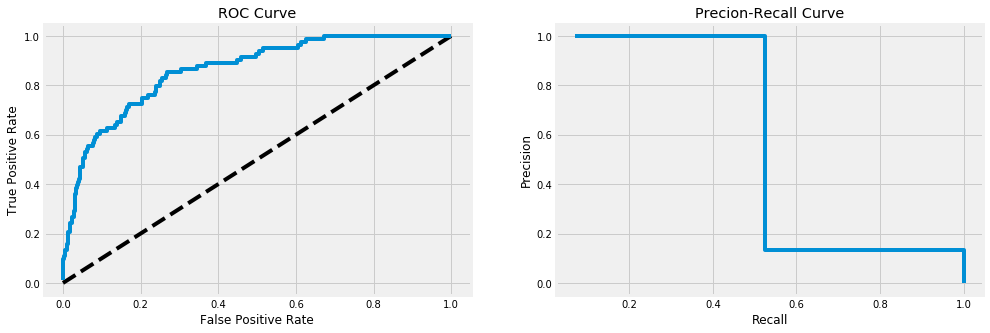

Accuracy on the training data is 0.929.
Accuracy on the test data is 0.929.
The model AUC for ROC curve of the test data is 0.861
Average precision is 0.132.


In [20]:
lr_model = model_performance(LogisticRegression())

In [21]:
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Without any optimization, we can predict patients who will convert to AD with 89% accuracy. Now, the classifier will be optimized.

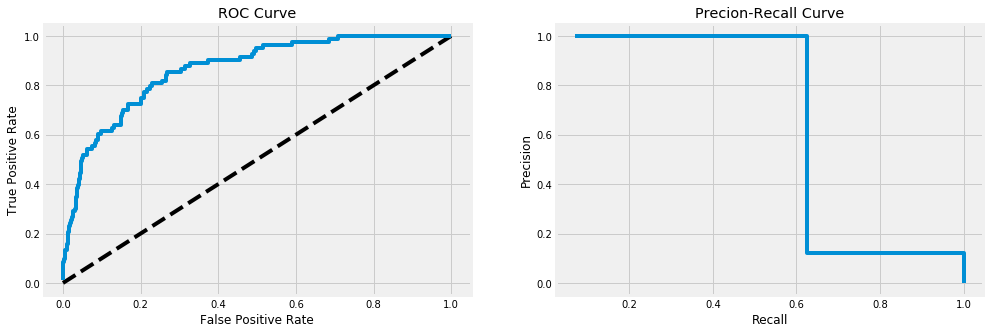

Accuracy on the training data is 0.93.
Accuracy on the test data is 0.932.
The model AUC for ROC curve of the test data is 0.864
Average precision is 0.138.
The best parameters are {'C': 0.1, 'penalty': 'l2'}.


In [22]:
# parameters to optimize
parameters = {'C' : [0.001, 0.1, 1, 10, 100], 'penalty' : ['l1', 'l2']}

# run grid search
lr_model = model_performance(GridSearchCV(LogisticRegression(random_state=42), param_grid=parameters, cv=skf), cv=True)

In [23]:
lr_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

With optimization, our accuracy is about the same. Last, let's look at relative importance of the different features by multiplying the assigned coefficient by the feature standard deviation.

Next, let's evaluate the performance of another classifier.

### 3.2 Random forest 

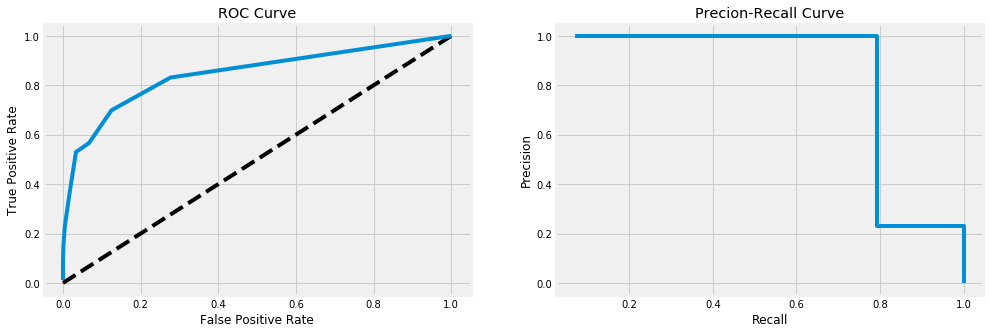

Accuracy on the training data is 0.992.
Accuracy on the test data is 0.94.
The model AUC for ROC curve of the test data is 0.845
Average precision is 0.237.


In [24]:
# evaluate random forest classifier
rf_model = model_performance(RandomForestClassifier())

In [25]:
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Without adjusting parameters, the random forest classifier slightly under performs a logistical regression one. Let's tune the hyperparameters.

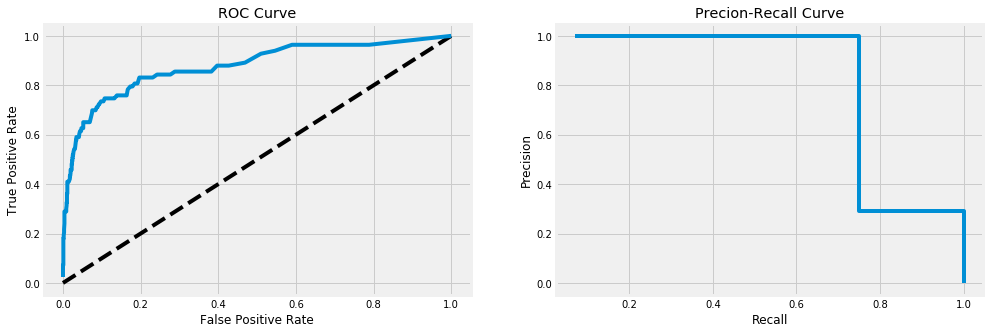

Accuracy on the training data is 1.0.
Accuracy on the test data is 0.942.
The model AUC for ROC curve of the test data is 0.877
Average precision is 0.268.
The best parameters are {'n_estimators': 311, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}.


In [27]:
# parameters to optimize
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameters = { 'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# run grid search
rf_model = model_performance(RandomizedSearchCV(RandomForestClassifier(n_jobs=4), param_distributions=parameters, n_iter=100, cv=skf), cv=True)

In [ ]:
rf_model

With optimization, the random forest classifier performs slightly better than the logistical regression model. However, it overfits the training data as the accuracy is 100%.

### 3.3 XGBoost classification

Here we will implement a popular boosting algorithm.

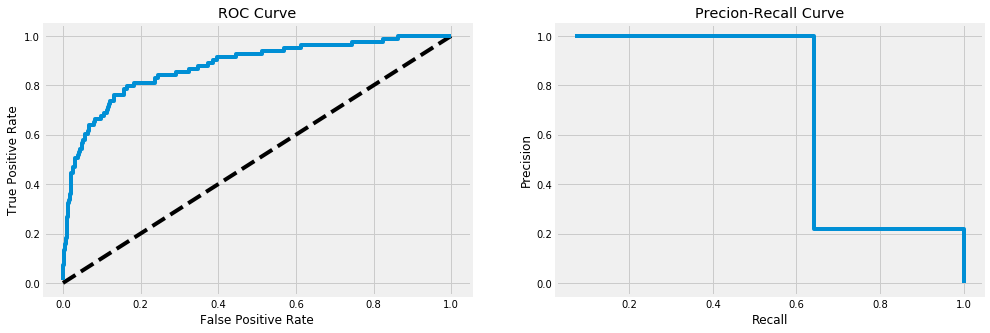

Accuracy on the training data is 0.952.
Accuracy on the test data is 0.935.
The model AUC for ROC curve of the test data is 0.876
Average precision is 0.196.


In [23]:
xg_model = model_performance(XGBClassifier())

In [ ]:
xg_model

In [45]:
parameters = {'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 
              'max_depth': [6, 7, 8],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5, 50, 100, 500, 1000]}

This model is close to the one produced using a random forest classifier, but does so without overfitting the training data.

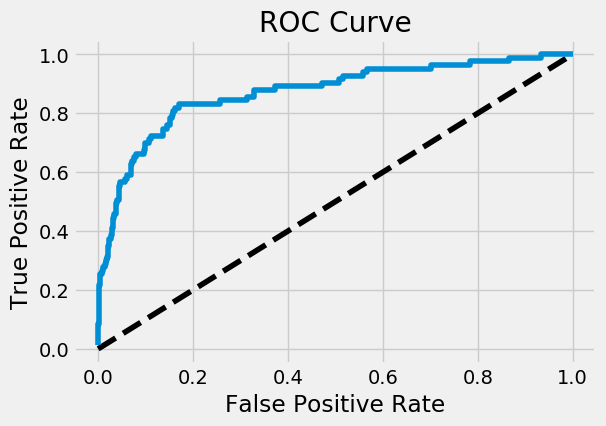

Accuracy on the training data is 0.983.
Accuracy on the test data is 0.938.
The model AUC for test data is 0.871
The best parameters are {'colsample_bytree': 0.7, 'learning_rate': 0.06, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 500, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8}.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'max_depth': [6, 7, 8], 'min_child_weight': [11], 'silent': [1], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [5, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
xg_model = model_performance(GridSearchCV(XGBClassifier(), param_grid=parameters, cv=skf), cv=True)

In [ ]:
xg_model

### 3.3 SVM 

In this section we'll evaluate the performance of a support vector machine.

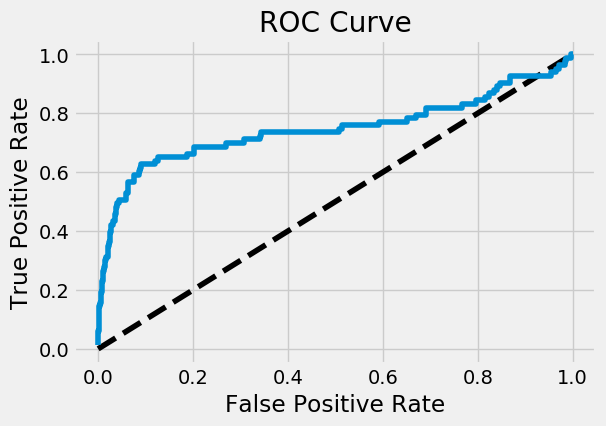

Accuracy on the training data is 0.937.
Accuracy on the test data is 0.934.
The model AUC for test data is 0.746


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
svc_model = model_performance(SVC(probability=True))

In [ ]:
svc_model

In [53]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

parameters = {'C' : C_range,
              'gamma' : gamma_range,
              'class_weight' : [None, 'balanced']}

In [ ]:
# run grid search
svc_model = model_performance(RandomizedSearchCV(SVC(probability=True), param_distributions=parameters, n_iter=100, cv=skf), cv=True)

In [ ]:
svc_model